# Credit Risk Data Exploration

This notebook demonstrates comprehensive data exploration techniques for credit risk datasets.

## Objectives:
- Load and examine credit risk datasets
- Perform data quality assessment
- Conduct exploratory data analysis (EDA)
- Identify patterns and relationships
- Generate insights for model development

In [1]:
# Auto-reload modules for easier debugging
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path so we can import our modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from data_loader import CreditDataLoader
from lending_club_preprocessing import LendingClubPreprocessor
from visualization import RiskVisualizer

# Plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Data Loading and Initial Inspection

In [2]:
# Initialize data loader
data_path = "../data"
loader = CreditDataLoader(data_path=data_path)

# Load Lending Club Data
print("Loading dataset... (this may take a moment)")
datasets = loader.load_lending_club(accepted_only=True)
accepted_df = datasets['accepted']

print(f"Successfully loaded data. Shape: {accepted_df.shape}")

Loading dataset... (this may take a moment)


INFO:data_loader:Loaded Lending Club accepted: (2260701, 151)


Successfully loaded data. Shape: (2260701, 151)


In [3]:
# Basic Data Quality Check (Raw Data)
print("--- Raw Data: Missing Values Analysis ---")
raw_missing = accepted_df.isnull().sum()
raw_missing_pct = (raw_missing / len(accepted_df)) * 100
missing_df_raw = pd.DataFrame({
    'Missing Count': raw_missing,
    'Missing %': raw_missing_pct
}).sort_values('Missing %', ascending=False)

print(f"Total columns with missing values: {len(missing_df_raw[missing_df_raw['Missing Count'] > 0])}")
display(missing_df_raw.head(10))

--- Raw Data: Missing Values Analysis ---
Total columns with missing values: 150


,Missing Count,Missing %
member_id,2260701,100.000000
orig_projected_additional_accrued_interest,2252050,99.617331
hardship_reason,2249784,99.517097
hardship_payoff_balance_amount,2249784,99.517097
hardship_last_payment_amount,2249784,99.517097
payment_plan_start_date,2249784,99.517097
hardship_type,2249784,99.517097
hardship_status,2249784,99.517097
hardship_start_date,2249784,99.517097
deferral_term,2249784,99.517097


In [4]:
# Apply Preprocessing
prep = LendingClubPreprocessor(include_pricing_features=False)
df = prep.prepare_accepted(accepted_df)

# Reset index to ensure clean dataframe
df = df.reset_index(drop=True)

print(f"Prepared Data Shape: {df.shape}")
print(f"Default Rate: {df['default'].mean():.2%}")
display(df.head())

Prepared Data Shape: (1345750, 116)
Default Rate: 20.01%


,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,disbursement_method,mths_since_last_delinq_missing,mths_since_last_record_missing,mths_since_last_major_derog_missing,revol_util_missing,dti_missing,annual_inc_missing,default,fico_avg,credit_history_len_months,pmt_to_inc,log_annual_inc
0,3600.0,3600.0,3600.0,36 months,123.03,10+ years,MORTGAGE,55000.0,Not Verified,2015-12-01,n,debt_consolidation,PA,5.91,0.0,2003-08-01,675.0,679.0,1.0,30.0,0.0,7.0,0.0,2765.0,0.297,13.0,w,564.0,560.0,0.0,30.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0,1,0,0,0,0,0,677.0,147.996058,0.026843,10.915107
1,24700.0,24700.0,24700.0,36 months,820.28,10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,n,small_business,SD,16.06,1.0,1999-12-01,715.0,719.0,4.0,6.0,0.0,22.0,0.0,21470.0,0.192,38.0,w,699.0,695.0,0.0,0.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0,1,1,0,0,0,0,717.0,191.984231,0.151436,11.082158
2,20000.0,20000.0,20000.0,60 months,432.66,10+ years,MORTGAGE,63000.0,Not Verified,2015-12-01,n,home_improvement,IL,10.78,0.0,2000-08-01,695.0,699.0,0.0,0.0,0.0,6.0,0.0,7869.0,0.562,18.0,w,704.0,700.0,0.0,0.0,Joint App,71000.0,13.85,Not Verified,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,NaN,10.0,NaN,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,1,1,1,0,0,0,0,697.0,183.968463,0.082411,11.050906
3,10400.0,10400.0,10400.0,60 months,289.91,3 years,MORTGAGE,104433.0,Source Verified,2015-12-01,n,major_purchase,PA,25.37,1.0,1998-06-01,695.0,699.0,3.0,12.0,0.0,12.0,0.0,21929.0,0.645,35.0,w,704.0,700.0,0.0,0.0,Individu

Top 10 Features Correlated with Default:


last_fico_range_high                  -0.667682
last_fico_range_low                   -0.575434
sec_app_fico_range_high               -0.252478
sec_app_fico_range_low                -0.252478
sec_app_mths_since_last_major_derog   -0.160750
sec_app_inq_last_6mths                 0.150582
sec_app_mort_acc                      -0.143042
sec_app_revol_util                     0.141725
dti_joint                              0.141623
fico_range_low                        -0.131057
Name: default, dtype: float64

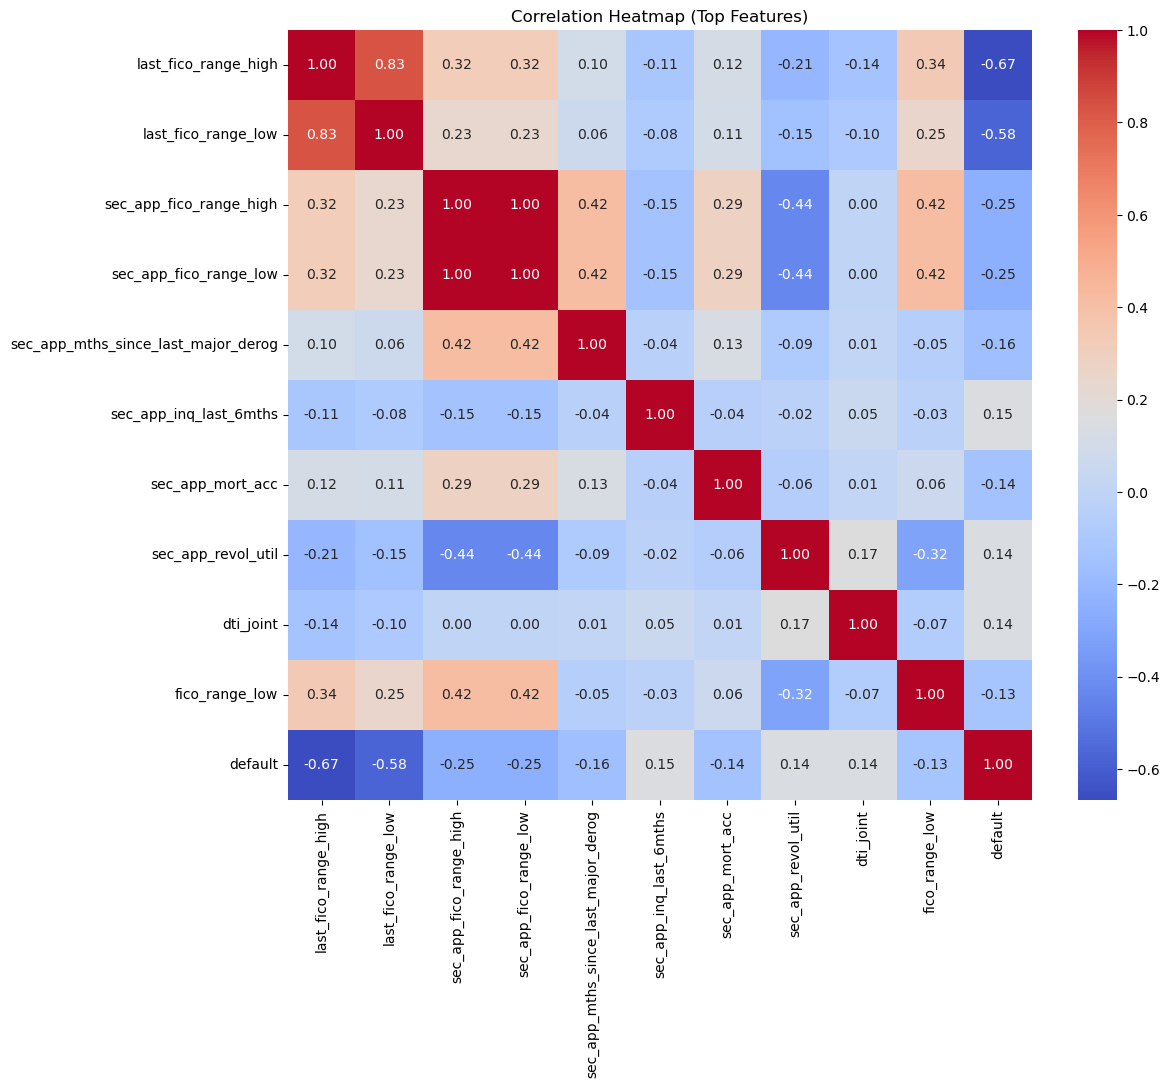

In [6]:
# Initialize visualizer
viz = RiskVisualizer()

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Calculate correlations with target
target_corr = numeric_df.corr()['default'].sort_values(key=abs, ascending=False)
target_corr = target_corr.drop('default')

print("Top 10 Features Correlated with Default:")
display(target_corr.head(10))

# Plot Heatmap of top features
top_features = target_corr.head(10).index.tolist() + ['default']
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df[top_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap (Top Features)")
plt.show()